# Load DataSet

In [2]:
# Load dataset and Process
import pandas as pd
import numpy as np
# Visualization
import matplotlib.pyplot as plt 
import seaborn as sns
# Maching Learning Tools
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
# Settings
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore',category=DeprecationWarning)
sns.set_style("whitegrid")

In [3]:
#Load the CSV file as df
#there are four columns:user_id, game_title, behavior, playhours
df=pd.read_csv('./Data/steam-200k.csv',usecols=[0,1,2,3],names=['user_id', 'game_title', 'behavior', 'playhours'])

In [4]:
# Display the first few rows to inspect the data
df.head()

,user_id,game_title,behavior,playhours
0,151603712,The Elder Scrolls V Skyrim,purchase,1.0
1,151603712,The Elder Scrolls V Skyrim,play,273.0
2,151603712,Fallout 4,purchase,1.0
3,151603712,Fallout 4,play,87.0
4,151603712,Spore,purchase,1.0


# Preprocessing Of Data

In [5]:
df.loc[(df['behavior'] == 'purchase') & (df['playhours'] == 1.0), 'playhours'] = 0

In [6]:
df.head()

,user_id,game_title,behavior,playhours
0,151603712,The Elder Scrolls V Skyrim,purchase,0.0
1,151603712,The Elder Scrolls V Skyrim,play,273.0
2,151603712,Fallout 4,purchase,0.0
3,151603712,Fallout 4,play,87.0
4,151603712,Spore,purchase,0.0


In [7]:
df=df.sort_values(['user_id','game_title','playhours'])

In [8]:
clean_df = df.drop_duplicates(['user_id', 'game_title','behavior']).drop(['behavior'], axis = 1)

In [9]:
'Totally include {} users and {} games'.format(clean_df.user_id.nunique(),clean_df.game_title.nunique())

'Totally include 12393 users and 5155 games'

In [10]:
n_users=clean_df.user_id.nunique()
n_games=clean_df.game_title.nunique()

sparsity=clean_df.shape[0]/(n_users*n_games)
'{:.2%} of the user-item matrix is filled'.format(sparsity)

'0.31% of the user-item matrix is filled'

## outlier detection

Box plot for playhours distribution by game (top 20 games for clarity)

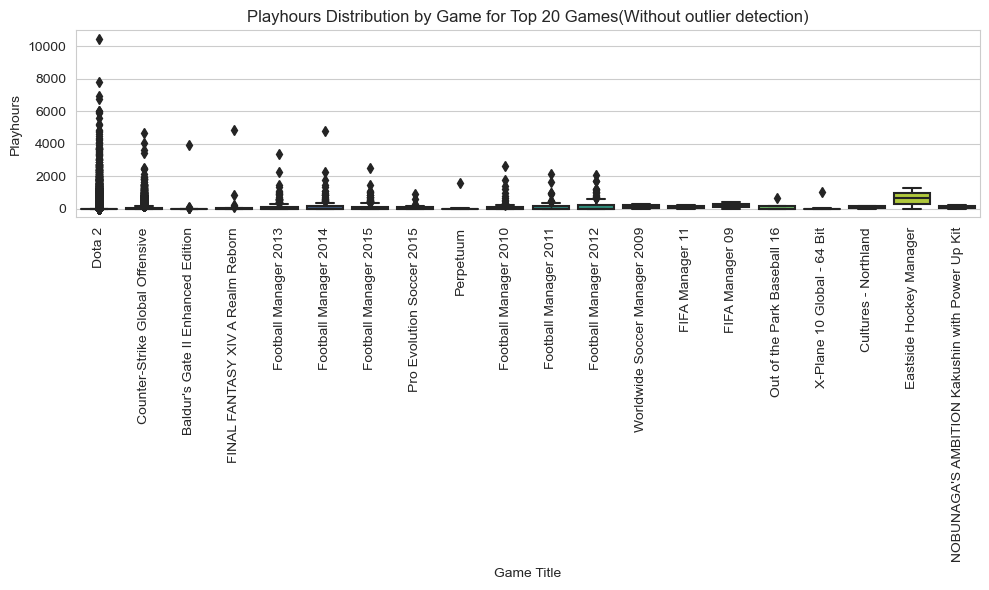

In [11]:
top_games = clean_df.groupby('game_title')['playhours'].mean().sort_values(ascending=False).head(30)
top_games_titles = top_games.index.tolist()[:20]
filtered_df_user = clean_df[clean_df['game_title'].isin(top_games_titles)]

plt.figure(figsize=(10, 6))
sns.boxplot(data=filtered_df_user, x='game_title', y='playhours', palette="viridis")
plt.title('Playhours Distribution by Game for Top 20 Games(Without outlier detection)')
plt.xlabel('Game Title')
plt.ylabel('Playhours')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [12]:
# Calculate the IQR and bounds for outliers for playhours
Q1_playhours = clean_df['playhours'].quantile(0.05)
Q3_playhours = clean_df['playhours'].quantile(0.95)
IQR_playhours = Q3_playhours - Q1_playhours
lower_bound_playhours = Q1_playhours - 1.5 * IQR_playhours
upper_bound_playhours = Q3_playhours + 1.5 * IQR_playhours

# Identify outliers based on the calculated bounds
outliers_playhours = clean_df[(clean_df['playhours'] < lower_bound_playhours) | (clean_df['playhours'] > upper_bound_playhours)]

In [13]:
# Remove the outliers from the dataset
clean_df_no_outliers = clean_df.drop(outliers_playhours.index)

# Display the first few rows of the updated dataset
clean_df_no_outliers.head()

,user_id,game_title,playhours
65429,5250,Alien Swarm,0.0
65430,5250,Alien Swarm,4.9
65423,5250,Cities Skylines,0.0
65435,5250,Counter-Strike,0.0
65436,5250,Counter-Strike Source,0.0


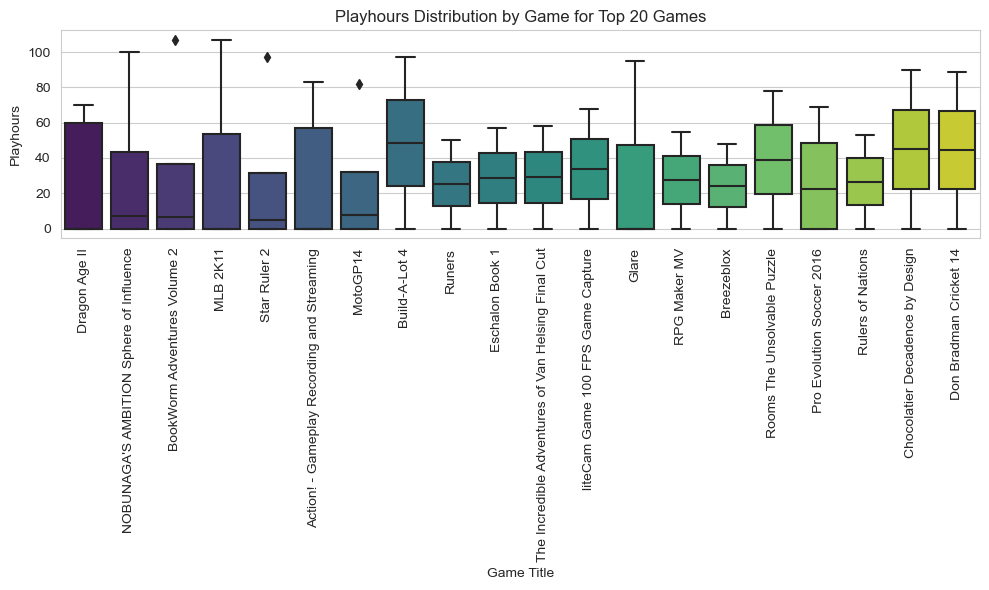

In [14]:
top_games = clean_df_no_outliers.groupby('game_title')['playhours'].mean().sort_values(ascending=False).head(30)
top_games_titles = top_games.index.tolist()[:20]
filtered_df_user = clean_df_no_outliers[clean_df_no_outliers['game_title'].isin(top_games_titles)]

plt.figure(figsize=(10, 6))
sns.boxplot(data=filtered_df_user, x='game_title', y='playhours', palette="viridis")
plt.title('Playhours Distribution by Game for Top 20 Games')
plt.xlabel('Game Title')
plt.ylabel('Playhours')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [15]:
clean_df_no_outliers.playhours.max()

117.0

In [16]:
# Modify the function to use the pre-calculated quantile values
def categorize_playhours_optimized(hours):
    if hours == 0:
        return 0
    elif hours < 20:
        return 1
    else:
        return 2

# Apply the optimized function to the playhours column to create a new rank column
clean_df_no_outliers['rank'] = clean_df_no_outliers['playhours'].apply(categorize_playhours_optimized)

# Visualization

In [17]:
clean_df_no_outliers.playhours.value_counts()

0.0      128804
0.2        3016
0.3        2517
0.4        2128
0.5        1813
          ...  
112.0        36
101.0        33
111.0        32
117.0        29
102.0        28
Name: playhours, Length: 298, dtype: int64

Histogram for user playhours distribution

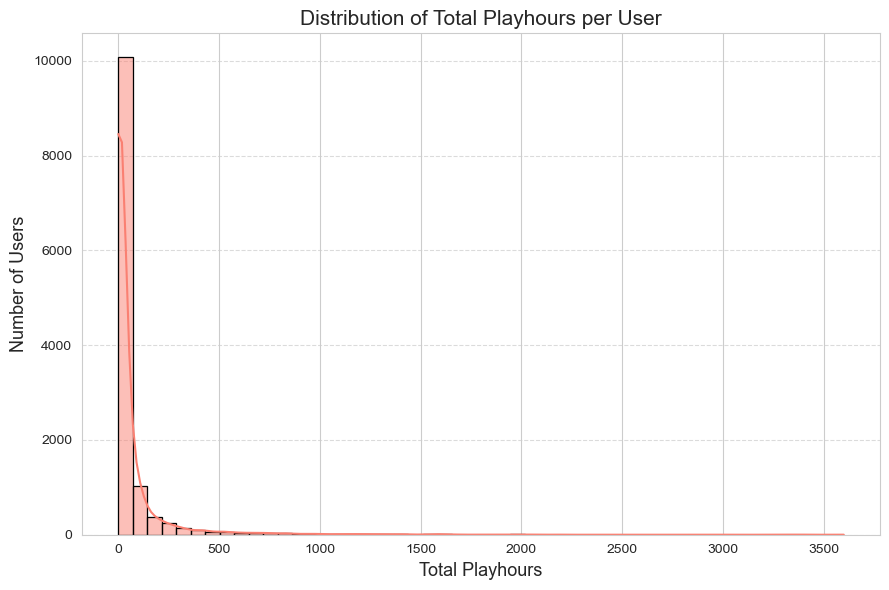

In [18]:
user_playhours = clean_df_no_outliers.groupby('user_id')['playhours'].sum()

plt.figure(figsize=(9, 6))
sns.histplot(user_playhours, bins=50, color='salmon', edgecolor='black', kde=True)
plt.title('Distribution of Total Playhours per User', fontsize=15)
plt.xlabel('Total Playhours', fontsize=13)
plt.ylabel('Number of Users', fontsize=13)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Bar plot for top 50 games with highest average playhours

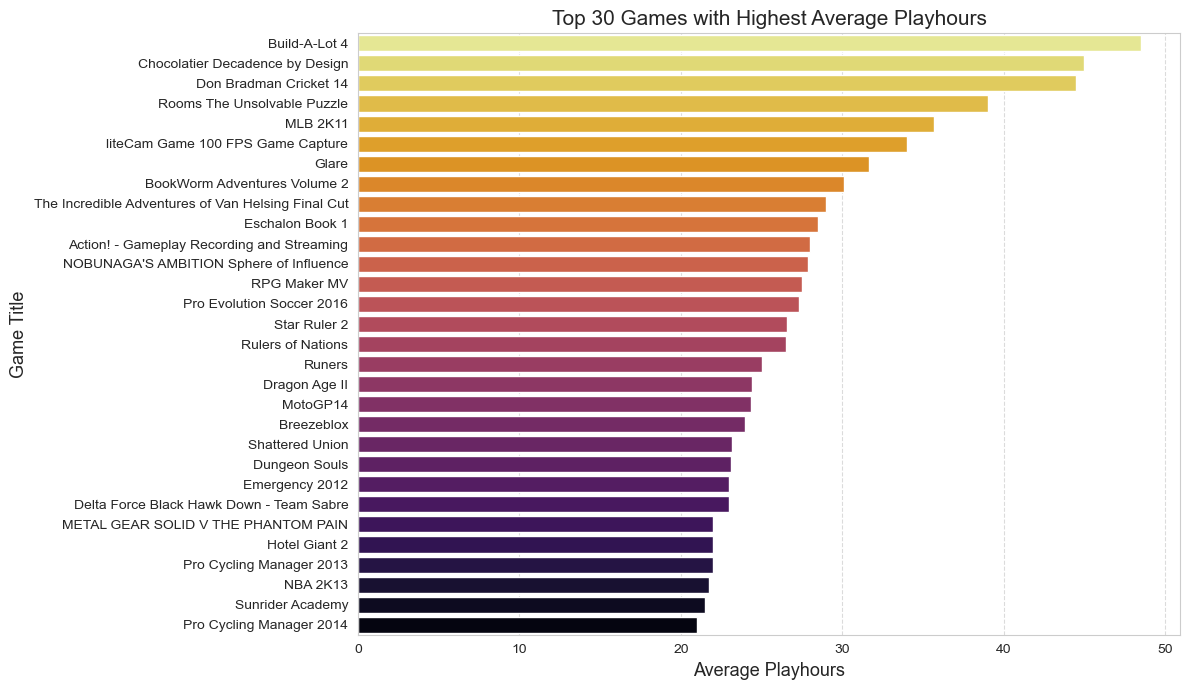

In [19]:
top_games = clean_df_no_outliers.groupby('game_title')['playhours'].mean().sort_values(ascending=False).head(30)

plt.figure(figsize=(12, 7))
sns.barplot(y=top_games.index, x=top_games.values, palette='inferno_r')
plt.title('Top 30 Games with Highest Average Playhours', fontsize=15)
plt.ylabel('Game Title', fontsize=13)
plt.xlabel('Average Playhours', fontsize=13)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Pie chart for playhours rank distribution

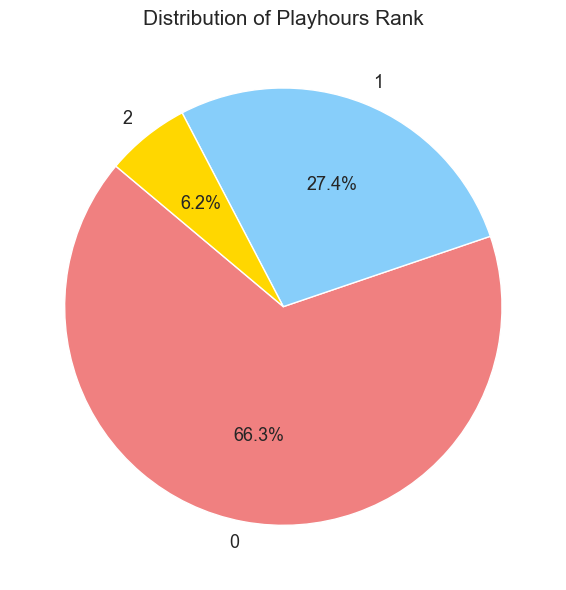

In [20]:
rank_distribution = clean_df_no_outliers['rank'].value_counts()

plt.figure(figsize=(9, 6))
colors = ['lightcoral', 'lightskyblue', 'gold']
plt.pie(rank_distribution, labels=rank_distribution.index, autopct='%1.1f%%', startangle=140, colors=colors, textprops={'fontsize': 13})
plt.title('Distribution of Playhours Rank', fontsize=15)
plt.tight_layout()
plt.show()

# Build a recommender system

Create a user-game_rank matrix with playhours as values

In [21]:
user_game_rank_matrix = clean_df_no_outliers.pivot_table(index='user_id', columns='game_title', values='rank', fill_value=0)

user_game_rank_matrix

game_title,007 Legends,0RBITALIS,1... 2... 3... KICK IT! (Drop That Beat Like an Ugly Baby),10 Second Ninja,"10,000,000",100% Orange Juice,1000 Amps,12 Labours of Hercules,12 Labours of Hercules II The Cretan Bull,12 Labours of Hercules III Girl Power,...,rFactor 2,realMyst,realMyst Masterpiece Edition,resident evil 4 / biohazard 4,rymdkapsel,sZone-Online,samurai_jazz,the static speaks my name,theHunter,theHunter Primal
user_id,,,,,,,,,,,,,,,,,,,,,
5250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0
76767,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0
86540,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0
103360,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0
144736,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309554670,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0
309626088,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0
309812026,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0


In [22]:
train_data, test_data=train_test_split(user_game_rank_matrix, train_size=0.7, random_state=42)

In [23]:
train_data.shape, test_data.shape

((8675, 5155), (3718, 5155))

## Using Kmeans algorithm to cluster the similar users

We can look at this line chart, and while it fluctuates but has an overall downward trend

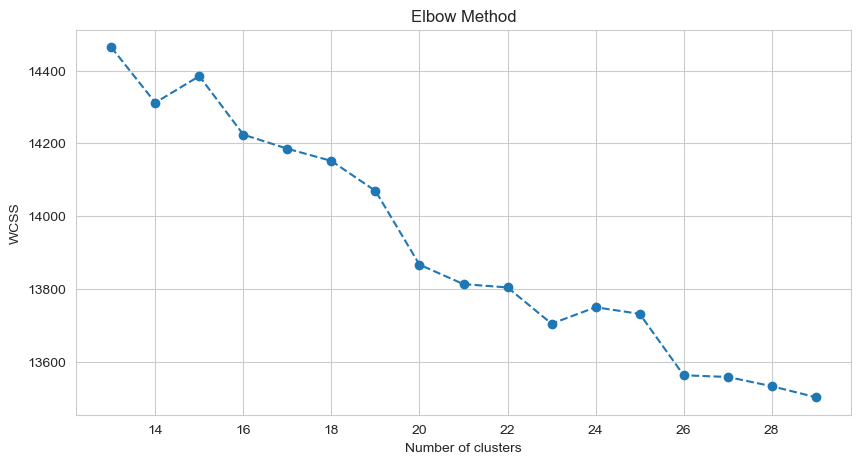

In [24]:
# Use the Elbow method to find a good number of clusters using WCSS (Within-Cluster-Sum-of-Squares)
wcss = []
range_values = range(13, 30)
for i in range_values:
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(train_data)
    wcss.append(kmeans.inertia_)

# Plot the Elbow method graph
plt.figure(figsize=(10,5))
plt.plot(range_values, wcss, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [25]:
# Use K-means clustering on the training data
km_best_model = KMeans(n_clusters=26, init='k-means++', random_state=42)
clusters_train_result = km_best_model.fit_predict(train_data).tolist()

In [26]:
train_index=train_data.index.to_list()

train_df = pd.DataFrame({
    'user_id':train_index,
    'clusters':clusters_train_result
})
train_df.head()

,user_id,clusters
0,34919318,2
1,235209794,8
2,71574303,12
3,202738708,8
4,87403553,12


In [27]:
train_df.clusters.unique()

array([ 2,  8, 12, 14, 18,  0, 23,  1, 19, 17,  5, 15, 13,  4, 21, 11,  6,
        3,  9,  7, 20, 16, 25, 22, 10, 24], dtype=int64)

In [28]:
clusters_test_result = km_best_model.predict(test_data)
test_index = test_data.index.to_list()

test_df = pd.DataFrame({
    'user_id':test_index,
    'clusters':clusters_test_result
})
test_df.head()

,user_id,clusters
0,242207850,0
1,235874009,0
2,178007464,0
3,74497511,8
4,80117314,8


In [29]:
result_df = pd.concat([train_df,test_df],axis=0)
result_df.clusters.value_counts()

8     5732
0     2642
12    1377
18     611
23     493
14     348
19     321
5      276
2      224
1      164
15      99
17      58
21      25
13      11
20       1
10       1
22       1
25       1
16       1
4        1
7        1
9        1
3        1
6        1
11       1
24       1
Name: clusters, dtype: int64

In [30]:
result_df

,user_id,clusters
0,34919318,2
1,235209794,8
2,71574303,12
3,202738708,8
4,87403553,12
...,...,...
3713,158828239,8
3714,174021956,0
3715,54293428,8
3716,228919399,5


In [31]:
clean_df_no_outliers_ = clean_df_no_outliers.set_index('user_id')

In [32]:
def KMeans_Recommender_System(user_id_,n_top=5):
    cluster_k=result_df[result_df.user_id == user_id_].clusters.values

    cluster_k_users = result_df[result_df.clusters == int(cluster_k)].user_id

    recommended_games = clean_df_no_outliers_.loc[cluster_k_users,:].game_title.value_counts()[:n_top].index.tolist()

    print("**************************************************")
    print("Here are top_{} games recommended for user:{}".format(n_top,user_id_))
    for num,game in enumerate(recommended_games):
        print("{}:{}".format(num+1,game))
    print("**************************************************")

In [33]:
KMeans_Recommender_System(54293428,n_top=10)

**************************************************
Here are top_10 games recommended for user:54293428
1:Unturned
2:Dota 2
3:Sid Meier's Civilization V
4:Left 4 Dead 2
5:The Elder Scrolls V Skyrim
6:Warframe
7:Half-Life 2 Lost Coast
8:Robocraft
9:Heroes & Generals
10:Half-Life 2 Deathmatch
**************************************************


## GaussianMixture


Determining the best number of components for Gaussian Mixture Model

I ran this code just once, because it takes an hour to run it once

In [34]:
n_components_range = range(1, 15)  # Trying values from 2 to 15
aics = []

for n in n_components_range:
    gmm = GaussianMixture(n_components=n, random_state=42)
    gmm.fit(train_data)
    aics.append(gmm.aic(train_data))

# Finding the number of components with the minimum AIC
best_n_components = np.argmin(aics) + 1  # adding 1 because index starts from 0

best_n_components, aics

In [35]:
# Extracting relevant columns for the model
X = clean_df_no_outliers[['playhours', 'rank']]

# Splitting the data into train and test sets
X_train, X_test = train_test_split(X, test_size=0.3, random_state=42)

In [36]:
# Training the Gaussian Mixture Model with n_components=2
gmm_best = GaussianMixture(n_components=2, random_state=42)
gmm_best.fit(X_train)

# Checking the convergence status
gmm_best.converged_

True

In [37]:
def GMM_Recommender_System(user_id, df, model, n_top=5):
    # Filtering out games the user has already played
    played_games = df[df['user_id'] == user_id]['game_title'].tolist()
    unplayed_games = df[~df['game_title'].isin(played_games)]
    
    # If the user has played all games
    if unplayed_games.empty:
        return ["The user has played all available games."]
    
    # Predicting probabilities for each unplayed game
    probabilities = model.predict_proba(unplayed_games[['playhours', 'rank']])
    
    # consider the component with the highest weight as the "recommended" cluster
    recommended_cluster = np.argmax(model.weights_)
    unplayed_games['probability'] = probabilities[:, recommended_cluster]
    
    # Recommending the games with the highest probabilities from the recommended cluster
    recommended_games = unplayed_games.sort_values(by='probability', ascending=False)['game_title'].unique().tolist()[:n_top]
    
    print("**************************************************")
    print("Here are top_{} games recommended for user:{}".format(n_top,user_id))
    for num,game in enumerate(recommended_games):
        print("{}:{}".format(num+1,game))
    print("**************************************************")

In [38]:
GMM_Recommender_System(54293428,clean_df_no_outliers,gmm_best,n_top=10)

**************************************************
Here are top_10 games recommended for user:54293428
1:Alien Swarm
2:ACE - Arena Cyber Evolution
3:Total War ATTILA
4:Total War ROME II - Emperor Edition
5:RAGE
6:Mafia II
7:60 Seconds!
8:Star Wars - Battlefront II
9:Alan Wake
10:Arma 2 DayZ Mod
**************************************************


C:\Users\yjy\AppData\Local\Temp\ipykernel_7144\2566483927.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unplayed_games['probability'] = probabilities[:, recommended_cluster]


## Item-based Collaborative Filtering

In [39]:
# calculate similarity of item
item_similarity = train_data.corr(method='pearson')

In [40]:
item_similarity.head()

game_title,007 Legends,0RBITALIS,1... 2... 3... KICK IT! (Drop That Beat Like an Ugly Baby),10 Second Ninja,"10,000,000",100% Orange Juice,1000 Amps,12 Labours of Hercules,12 Labours of Hercules II The Cretan Bull,12 Labours of Hercules III Girl Power,...,rFactor 2,realMyst,realMyst Masterpiece Edition,resident evil 4 / biohazard 4,rymdkapsel,sZone-Online,samurai_jazz,the static speaks my name,theHunter,theHunter Primal
game_title,,,,,,,,,,,,,,,,,,,,,
007 Legends,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0RBITALIS,NaN,1.000000,-0.000326,0.499885,-0.000163,-0.000308,-0.000163,-0.000365,-0.000365,-0.000163,...,NaN,-0.000231,NaN,-0.000489,-0.000163,-0.001046,NaN,-0.000461,-0.001511,-0.000266
1... 2... 3... KICK IT! (Drop That Beat Like an Ugly Baby),NaN,-0.000326,1.000000,-0.000326,-0.000231,-0.000436,-0.000231,-0.000516,-0.000516,-0.000231,...,NaN,-0.000326,NaN,-0.000692,-0.000231,0.076810,NaN,-0.000653,-0.002137,-0.000377
10 Second Ninja,NaN,0.499885,-0.000326,1.000000,-0.000163,-0.000308,-0.000163,-0.000365,-0.000365,-0.000163,...,NaN,-0.000231,NaN,-0.000489,-0.000163,-0.001046,NaN,-0.000461,-0.001511,-0.000266
"10,000,000",NaN,-0.000163,-0.000231,-0.000163,1.000000,-0.000218,-0.000115,-0.000258,-0.000258,-0.000115,...,NaN,-0.000163,NaN,-0.000346,-0.000115,-0.000740,NaN,-0.000326,-0.001068,-0.000188


In [41]:
# Replace all NaN values with 0
item_similarity = item_similarity.fillna(0)

# Set the diagonal elements to 1
np.fill_diagonal(item_similarity.values, 1)

In [42]:
item_similarity.head()

game_title,007 Legends,0RBITALIS,1... 2... 3... KICK IT! (Drop That Beat Like an Ugly Baby),10 Second Ninja,"10,000,000",100% Orange Juice,1000 Amps,12 Labours of Hercules,12 Labours of Hercules II The Cretan Bull,12 Labours of Hercules III Girl Power,...,rFactor 2,realMyst,realMyst Masterpiece Edition,resident evil 4 / biohazard 4,rymdkapsel,sZone-Online,samurai_jazz,the static speaks my name,theHunter,theHunter Primal
game_title,,,,,,,,,,,,,,,,,,,,,
007 Legends,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
0RBITALIS,0.0,1.000000,-0.000326,0.499885,-0.000163,-0.000308,-0.000163,-0.000365,-0.000365,-0.000163,...,0.0,-0.000231,0.0,-0.000489,-0.000163,-0.001046,0.0,-0.000461,-0.001511,-0.000266
1... 2... 3... KICK IT! (Drop That Beat Like an Ugly Baby),0.0,-0.000326,1.000000,-0.000326,-0.000231,-0.000436,-0.000231,-0.000516,-0.000516,-0.000231,...,0.0,-0.000326,0.0,-0.000692,-0.000231,0.076810,0.0,-0.000653,-0.002137,-0.000377
10 Second Ninja,0.0,0.499885,-0.000326,1.000000,-0.000163,-0.000308,-0.000163,-0.000365,-0.000365,-0.000163,...,0.0,-0.000231,0.0,-0.000489,-0.000163,-0.001046,0.0,-0.000461,-0.001511,-0.000266
"10,000,000",0.0,-0.000163,-0.000231,-0.000163,1.000000,-0.000218,-0.000115,-0.000258,-0.000258,-0.000115,...,0.0,-0.000163,0.0,-0.000346,-0.000115,-0.000740,0.0,-0.000326,-0.001068,-0.000188


In [43]:
def get_similar_games(game_title, n_top=10):
    """
    Get the top n_top games that are most similar to the game.
    """
    similar_games = item_similarity[game_title].sort_values(ascending=False)[:n_top]
    return similar_games


def predict_rating(user_id, game_title):
    """
    Predict the rating of a user for a game.
    """
    # Get the similarity games for the game
    similarity_games = get_similar_games(game_title)

    # Get the user's ratings for these games
    user_ratings = user_game_rank_matrix.loc[user_id, similarity_games.index]

    # Predict the rating
    predicted_rating = np.dot(user_ratings, similarity_games) / np.sum(similarity_games)

    return predicted_rating

In [44]:
def CF_Recommender_System(user_id, n_top=5):
    """
    Recommend the top n_top games for a user.
    """
    # Get the user's ratings
    user_ratings = user_game_rank_matrix.loc[user_id, :]

    # Get the games that the user hasn't rated yet
    unrated_games = user_ratings[user_ratings == 0].index

    # Predict the ratings for these games
    predicted_ratings = {game: predict_rating(user_id, game) for game in unrated_games}

    # Sort the games by the predicted ratings
    sorted_games = sorted(predicted_ratings, key=predicted_ratings.get, reverse=True)

    # Get the top n_top games
    recommended_games = sorted_games[:n_top]

    print("**************************************************")
    print("Here are top_{} games recommended for user:{}".format(n_top,user_id))
    for num,game in enumerate(recommended_games):
        print("{}:{}".format(num+1,game))
    print("**************************************************")

In [45]:
CF_Recommender_System(54293428,10)

**************************************************
Here are top_10 games recommended for user:54293428
1:Airline Tycoon Deluxe
2:Children of the Nile Alexandria
3:Farming Giant
4:Universal Combat CE
5:Imperium Romanum Gold Edition
6:LEGO The Hobbit
7:Dark Souls Prepare to Die Edition
8:Cities Skylines
9:Delta Force Black Hawk Down
10:Terraria
**************************************************
